# My Qiskit Implementation of the Quantum Phase Estimator

This is my implementation of the phase estimator algorithm, which is also the Inverse Quantum Fourier Transform. This code was inspired by this [edX course by TU Delft](https://www.edx.org/course/architecture-algorithms-quantum-computer-internet). This implementation makes use of IBM's Qiskit language, with the possibility of running the circuit on either a simulator or on an actual IBM quantum computer.

## Motivation

The idea behind this algorithm is to estimate/measure the phase introduced by a unitary operator of the form

<p style="text-align: center;">
$U = \begin{pmatrix} 
1 & 0 \\ 
0 & e^{i\phi}
\end{pmatrix}$.
</p>

When applied to the state $\left|+\right\rangle$, this unitary gives:

<p style="text-align: center;">
$U \left|+\right\rangle = U (\left| 0\right\rangle+ \left| 1\right\rangle))/\sqrt{2} = (\left|0\right\rangle + e^{i\phi}\left|1\right\rangle)/\sqrt{2}$.
</p>

So it adds a relative phase to the second component, $\left|1\right\rangle$, of the state. If we were to measure the resulting state, we would not be able to learn about the value of $\phi$, as the state would collapse to either $\left|0\right\rangle$ or $\left|1\right\rangle$ with 50% probability for each.

This method then comes to the rescue. Given a gate which implements the unitary operation, $U$, we can estimate the phase $\phi$, assuming we can use the gate multiple times. The algorithm takes advantage of the fact that if we apply $U$ multiple times we get, for example: 

<p style="text-align: center;">
$U^2 \left|+\right\rangle = (\left|0\right\rangle + e^{i.2\phi}\left|1\right\rangle)/\sqrt{2}$, and
</p>

<p style="text-align: center;">
$U^4 \left|+\right\rangle = (\left|0\right\rangle + e^{i.4\phi}\left|1\right\rangle)/\sqrt{2}$, etc.
</p>

And, eventually if for some integer, $n$, the value of $n\phi$ exceeds $2\pi$, then we would be implementing a phase of $n\phi-2\pi$, or more accurately $n\phi$ ``mod`` $2\pi$. So by applying $U$ $2^n$ times for $n=1,2,3,...$ we can learn about $\phi$ more and more precisely.

[Here](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html) is a good place to read about the phase estimator in more detail.

## Preliminaries

Before introducing the code, here are some preliminaries. We write our angle $\phi$ as 

<p style="text-align: center;">
$\phi = 2\pi \times f$,
</p>

in other words, as a fraction of $2\pi$.

Let's say $\phi=\pi$, then $f=1/2$. We then write $f$ as a _binary fraction:_ $f=0.1$. In binary fractions:

<p style="text-align: center;">
$0.5 = 2^{-1} \rightarrow 0.1$
</p>

<p style="text-align: center;">
$0.25 = 2^{-2} \rightarrow 0.01$
</p>

<p style="text-align: center;">
$0.75 = 2^{-1}+2^{-2} \rightarrow 0.11$, 
</p>

and so on.

The following circuit returns the value of $f$ in this binary fraction format, starting at the first digit after the decimal point. (Since $f<1$ there is no digits before the decimal point!) For example if $f=0.1011$ in binary, the returned qubits at the end of the circuit will be 1, 0, 1 and 1, in this order.

## The code

I implement the phase estimator as a class, ``Phase_est``, which can be instatiated with one argument, which is the value of $f$. In the code I called it ``phi``, however. When a ``Phase_est`` object is created, a Qiskit circuit is built. The ``draw()`` method used to display the circuit, and the ``ex()`` method to execute it. By default, the code will run on the local simulator included with the Qiskit package. However, to run it on an actual IBM quantum computer, create an object with ``mycircuit = Phase_est(f, sim=False)``, which will pick the machine with the right number of qubits, and with the least number of jobs in the queue.

To plot the results, the method ``res()`` is used. If we're using a real quantum computer (not the simulator,) ``res()`` will check the status of the job. If the results are not ready yet, an exception is returned.

In [2]:
import numpy as nn
import matplotlib.pyplot as pl

import qiskit
import qiskit.tools.visualization as qviz 
from qiskit import IBMQ

class Phase_est :

    # the argument of __init__ is phi as a fraction of 2pi, 
    # which is called f, in the text
    def __init__(self, phi, sim=True) :
    
        self.phi = phi
        self.sim = sim
        self.be = None
    
        # Find the number required bits for exact answer, up to a 
        # maximum of 8 bits
        nbits=1
        while phi * 2**nbits % 1 != 0 and nbits <= 8 : nbits=nbits+1
        nbits = min(nbits, 8)
        self.nbits = nbits
        
        # create circuit with nbits qubits, and nbits classical
        # measurement channels if no simulator
        if sim : qc = qiskit.QuantumCircuit(nbits)
        else : qc = qiskit.QuantumCircuit(nbits, nbits)
        
        for iq in range(nbits) :
        
            # Initial Hadamard and rotation to prepare each qubit
            # in the Fourier state, so we inverse-Fourier transform it
            qc.h(iq)
            qc.u1( (( 2**(nbits-1-iq) *phi) % 1) * 2*nn.pi, iq )
        
        qc.barrier()
        
        for iq in range(nbits) :
            
            # this Hadamard acts like a measurement on the 
            # first bit after the decimal in binary representation
            # of phi
            qc.h(iq)
            
            # subtract this "measured" bit from the next qubit's
            # next significant figure
            for iq2 in range(iq+1, nbits) :
                qc.cu1( -nn.pi/2**(iq2-iq), iq2, iq )
        
        # Include measurement if we're using a real QC
        if not sim : qc.measure(range(nbits), range(nbits))
        
        self.qc = qc
        



    def draw(self) :
    
        # Draw circuit
        fig, ax = pl.subplots()
        qviz.circuit_drawer(self.qc, output='mpl', ax=ax)
        #ax.set_title(self.be.name())
        
        
    def ex(self, be=None) :
        
        # Before executing, check if the execution was not
        # run before, by check for the existence of self.job
        try :
            if self.job.status() != self.job.status().DONE :
                raise Exception("Still working on previous run")
        except AttributeError :
            pass
        
        # If the backend is specified, use it.
        if be!=None : 
            if be=='statevector_simulator' :
                self.be = qiskit.Aer.get_backend('statevector_simulator')
            else : 
                if len(IBMQ.get_provider().backends(be)) > 0:
                    self.be = IBMQ.get_provider().backends(be)[0]
                else : 
                    self.be = qiskit.Aer.get_backend('statevector_simulator')
                    print()
                    print('Incorrect backend name. Using the simulator.')
                    print()
                
        # choose the QC/simulator backend
        elif not self.sim : 
            
            # Load IBMQ account, if it's not already loaded
            if IBMQ.active_account()==None : IBMQ.load_account()

            if self.be==None or self.be.name()=='statevector_simulator' :
                
                # If we need 5 qubits or less, pick one of the quantum 
                # processors with 5 qubits
                if self.nbits <= 5 :
                    be5q=IBMQ.get_provider().backends(simulator=False, 
                                                      filters=lambda x: x.configuration().n_qubits==5)
                    self.be = qiskit.providers.ibmq.least_busy(be5q)
                    
                # If nbits between 6 and 15 inclusive, then use the Melbourne
                # quantum processor
                elif self.nbits <= 15 : 
                    # 16-qubit quantum computer
                    self.be=IBMQ.get_provider().backends('ibmq_16_melbourne')[0]
                    
                # Don't run if nbits >= 16
                else :
                    raise Exception("Too many qubits for available physical backends. Try simulator.")
        
            print()
            print('Using backend = ', self.be.name())
            print()
        
        # simulator specified
        else :    
            self.be = qiskit.Aer.get_backend('statevector_simulator')
        
        # execution ===============
        self.job = qiskit.execute(self.qc, self.be)
        # =========================
        
    # Plot results
    def res(self) :
        
        # check if results are ready in the case of using a QC backend
        if self.be.name()=='statevector_simulator' or self.job.done() :

            # results
            res = self.job.result()
            cts = res.get_counts()
            
            # plot results
            return qviz.plot_histogram(cts, title=self.be.name())

        else : 
            raise Exception('Job not ready yet. Status = '+ str(self.job.status()))

## Simulation Run

Let's start by simulating the quantum phase estimator for $f=3/8=1/4+1/8$, which in binary fraction is $f=0.011$. This corresponds to an angle $\phi=3\pi/4$. We start by creating the circuit:

In [12]:
qc = Phase_est(3/8, sim=True)

Then, we draw it:

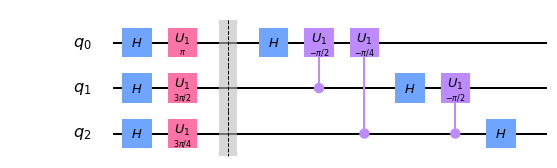

In [13]:
qc.draw()

Notice a few things:
* To the left of a barrier is a Hadamard gate and a rotation. This pair of gates prepares the state, which will then be fed to the inverse Fourier transform part of the circuit, to the right of the barrier.
* The $U_1$ gate corresponds to the a unitary operation of the same form as U, above, where the angle is marked on the gate. If we go from bottom to top, the rotation angles are $3\pi/4$, $3\pi/2$ and $3\pi$, which has been changed to $\pi$, because it is equivalent. This is as described in the introduction above.

We can then run the circuit:

In [14]:
qc.ex()

Plot the results:

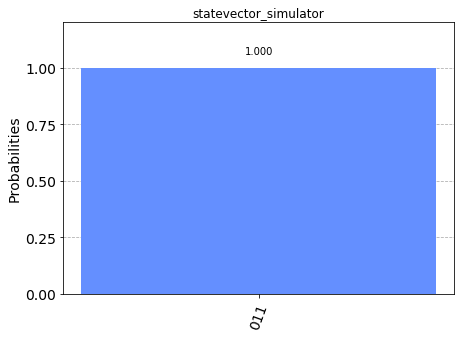

In [15]:
qc.res()

In this case, the answer recovered is '011' corresponding to the digits after the decimal point in the binary fraction representation of $f=0.011$.

Another way to look at this, since this is a simulation, is to look at the calculated state vector. This would not be available if this was run on an actual quantum computer. The state vector can be accessed by accessing the ``job`` attribute of ``qc``, which is an instance of the Qiskit ``Job`` class.

In [16]:
qc.job.result().get_statevector()

array([ 2.28450564e-17+1.67383822e-17j, -3.39479767e-17+1.73684940e-16j,
       -4.44939578e-17+1.55516260e-16j,  1.00000000e+00-3.88594719e-16j,
        9.38984348e-17-6.65283447e-17j,  1.90957223e-16-5.12202597e-17j,
        3.87727691e-17+1.67383822e-17j,  2.50927311e-32+1.43665359e-16j])

## Run on an IBM Quantum Computer

Now, let's run the circuit on an actual IBM quantum computer. This time, I'll change the angle to $\phi=5\pi/8$, or $f=0.101$.

I will create the circuit, execute it, and then immediately try to access the results. Typically, the jobs are queued on the IBM quantum computers, which makes them not available immediately. I have included this in the ``res()`` function, which will raise and exception if it finds the results not ready, as seen below.

In [17]:
qc2 = Phase_est(5/8, sim=False)
qc2.ex()
qc2.res()


Using backend =  ibmq_essex



Exception: Job not ready yet. Status = JobStatus.VALIDATING

Let me also, draw the circuit:

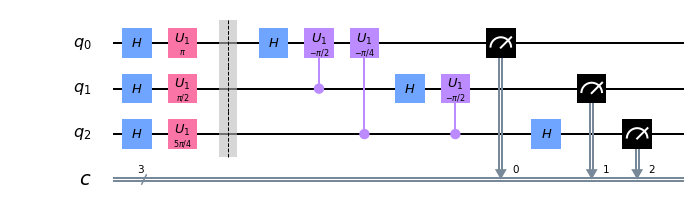

In [23]:
qc2.draw()

You'll notice this time additional measurement boxes. These are necessary when we run on a physical quantum computer. I made the ``Phase_est`` class add them when a physical backend is chosen.

In [18]:
# after waiting some time...
qc2.res()

Exception: Job not ready yet. Status = JobStatus.QUEUED

We can get information about the position of our job in the queue:

In [19]:
qc2.job.queue_info()

<QueueInfo(job_id='5e9a8f5fc73c1d0018b4a3f2', _status='job is queued', estimated_start_time='2020-04-18T05:29:00.480000+00:00', estimated_complete_time='2020-04-18T05:29:31.880000+00:00', position=3, hub_priority=1.0, group_priority=1.0, project_priority=1.0)>

In [20]:
qc2.job.queue_position()

3

After some time, we find:

In [21]:
qc2.job.status()

<JobStatus.DONE: 'job has successfully run'>

So now, we can finally get the results:

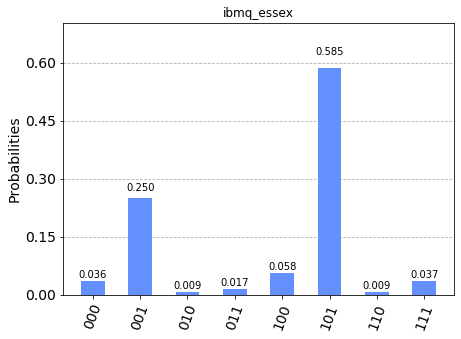

In [22]:
qc2.res()

OK. First things first: I have just run a program on a **QUANTUM COMPUTER**. I hope you get to run this yourself, and get the same excitement I got the first time I ran it. We have the opportunity to play with a technology which could revolutionize the world, perhaps a few decades later!

Second, well we do recover our expected '101', but now it's not the only solution. There are other solutions, such as '001', the second most likely solution, which are returned. The other solutions are due to the noisy nature of today's quantum computers.

Hope you get to try this out for yourself. Download the Qiskit library in Python, and enjoy!